# Player Comparison EDA

This notebook builds exploratory tools to compare player seasons across teams
and years, with the goal of supporting transfer impact analysis.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [ ]:
## Configure Display Settings and Locate Season Data

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

SEASON = 2017
DATA_DIR = Path(f"../data/{SEASON}")

files = list(DATA_DIR.glob("*.csv"))
print("DATA_DIR:", DATA_DIR.resolve())
print("num files:", len(files))
files[:3]

DATA_DIR: /Users/daniellenney/Desktop/BSA/2026_Transfer_Project/BSA-Basketball-W26/data/2017
num files: 347


[PosixPath('../data/2017/seattle_wbb_2017.csv'),
 PosixPath('../data/2017/montana-state_wbb_2017.csv'),
 PosixPath('../data/2017/elon_wbb_2017.csv')]

In [ ]:
## Load and Combine Team-Level Player Data for Selected Season

dfs = []
for f in files:
    df = pd.read_csv(f)
    df["season"] = SEASON
    df["school"] = f.stem.replace(f"_wbb_{SEASON}", "")
    dfs.append(df)

season_df = pd.concat(dfs, ignore_index=True, sort=False)
# season_df.head(10)

In [46]:
# season_df.dtypes



In [ ]:
## Assemble Multi-Season Player Dataset

all_dfs = []

for SEASON in range(2017, 2027):
    DATA_DIR = Path(f"../data/{SEASON}")
    files = list(DATA_DIR.glob("*.csv"))
    
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        df["season"] = SEASON
        df["school"] = f.stem.replace(f"_wbb_{SEASON}", "")
        dfs.append(df)

    season_df = pd.concat(dfs, ignore_index=True, sort=False)
    all_dfs.append(season_df)

all_df = pd.concat(all_dfs, ignore_index=True, sort=False)
#all_df.shape


In [ ]:
## Validate Season Coverage and Define Core Statistics

all_df["season"].value_counts().sort_index()
CORE_STATS = [
    "mp_per_g", "pts_per_g", "fga_per_g",
    "fg_pct", "fg3a_per_g", "fg3_pct",
    "efg_pct", "ast_per_g", "trb_per_g",
    "stl_per_g", "blk_per_g", "tov_per_g"
]

player_seasons_sorted = (
    all_df
    .sort_values(["player_sr_link", "season"])
    .copy()
)
# player_seasons_sorted.shape
# player_seasons_sorted.head(10)




In [ ]:
## Align Player Seasons and Attach Next-Season Statistics

for s in CORE_STATS:
    player_seasons_sorted[f"next_{s}"] = (
        player_seasons_sorted
        .groupby("player_sr_link")[s]
        .shift(-1)
    )

player_seasons_sorted["next_season"] = (
    player_seasons_sorted
    .groupby("player_sr_link")["season"]
    .shift(-1)
)
# player_seasons_sorted.shape
# player_seasons_sorted.head(10)

In [ ]:
## Construct Year-to-Year Player Comparison Table

year_to_year_pairs = player_seasons_sorted[
    player_seasons_sorted["next_season"] == player_seasons_sorted["season"] + 1
].copy()

for s in CORE_STATS:
    year_to_year_pairs[f"delta_{s}"] = (
        year_to_year_pairs[f"next_{s}"] - year_to_year_pairs[s]
    )
# year_to_year_pairs.head(10)


In [ ]:
## Define Function to Build a Year-to-Year Player Performance Profile

def build_player_yoy_profile(
    year_to_year_pairs: pd.DataFrame,
    player_sr_link: str,
    season: int,
    core_stats: list[str],
) -> dict:
    """
    Build a year-to-year comparison profile for a single player from season -> season+1.

    Returns:
      {
        "meta": {...},
        "comparison": DataFrame(index=stats, columns=["t", "t_plus_1", "delta"])
      }
    """
    # filter to the exact player-season row
    mask = (year_to_year_pairs["player_sr_link"] == player_sr_link) & (year_to_year_pairs["season"] == season)
    row_df = year_to_year_pairs.loc[mask]

    if row_df.empty:
        raise ValueError("No consecutive-year record found for that player and season.")
    if len(row_df) > 1:
        # This should not happen if player_sr_link+season is unique, but guard anyway
        row_df = row_df.iloc[[0]]

    row = row_df.iloc[0]

    # Build comparison for every CORE_STAT
    comp = pd.DataFrame(index=core_stats, columns=["t", "t_plus_1", "delta"], dtype="float64")
    for s in core_stats:
        comp.loc[s, "t"] = row[s]
        comp.loc[s, "t_plus_1"] = row.get(f"next_{s}", np.nan)
        comp.loc[s, "delta"] = row.get(f"delta_{s}", np.nan)

    # Add derived: 3PA rate (and delta)
    # Use per-game attempts; safe division
    fga_t = row.get("fga_per_g", np.nan)
    fga_t1 = row.get("next_fga_per_g", np.nan)

    rate_t = row.get("fg3a_per_g", np.nan) / fga_t if pd.notna(fga_t) and fga_t != 0 else np.nan
    rate_t1 = row.get("next_fg3a_per_g", np.nan) / fga_t1 if pd.notna(fga_t1) and fga_t1 != 0 else np.nan

    comp.loc["fg3a_rate", "t"] = rate_t
    comp.loc["fg3a_rate", "t_plus_1"] = rate_t1
    comp.loc["fg3a_rate", "delta"] = rate_t1 - rate_t if pd.notna(rate_t) and pd.notna(rate_t1) else np.nan

    meta = {
        "player_name": row["player_name"],
        "player_sr_link": row["player_sr_link"],
        "school_t": row["school"],
        "school_t_plus_1": row.get("next_school", None),  # may not exist yet
        "season_t": int(row["season"]),
        "season_t_plus_1": int(row["next_season"]),
    }

    return {"meta": meta, "comparison": comp}


In [53]:
## Helper Function: Search for Players by Name
def lookup_players(pairs: pd.DataFrame, name_query: str, n: int = 15) -> pd.DataFrame:
    out = pairs[pairs["player_name"].str.contains(name_query, case=False, na=False)]
    return (
        out[["player_name", "player_sr_link", "school", "season"]]
        .drop_duplicates()
        .sort_values(["player_name", "season"])
        .head(n)
    )


In [ ]:
lookup_players(year_to_year_pairs, "Clark")


In [55]:
## Build Year-to-Year Performance Profile for a Selected Player

# Select Caitlin Clark (2022 → 2023)
player_id = lookup_players(year_to_year_pairs, "Caitlin Clark").iloc[1]["player_sr_link"]
season = 2022

profile = build_player_yoy_profile(
    year_to_year_pairs=year_to_year_pairs,
    player_sr_link=player_id,
    season=season,
    core_stats=CORE_STATS
)

profile["meta"], profile["comparison"]



({'player_name': 'Caitlin Clark',
  'player_sr_link': 'https://www.sports-reference.com/cbb/players/caitlin-clark-1.html',
  'school_t': 'iowa',
  'school_t_plus_1': None,
  'season_t': 2022,
  'season_t_plus_1': 2023},
                     t   t_plus_1     delta
 mp_per_g    35.800000  34.400000 -1.400000
 pts_per_g   27.000000  27.800000  0.800000
 fga_per_g   19.800000  18.800000 -1.000000
 fg_pct       0.452000   0.473000  0.021000
 fg3a_per_g   8.600000   9.500000  0.900000
 fg3_pct      0.332000   0.389000  0.057000
 efg_pct      0.524000   0.571000  0.047000
 ast_per_g    8.000000   8.600000  0.600000
 trb_per_g    8.000000   7.100000 -0.900000
 stl_per_g    1.500000   1.500000  0.000000
 blk_per_g    0.600000   0.500000 -0.100000
 tov_per_g    4.800000   4.200000 -0.600000
 fg3a_rate    0.434343   0.505319  0.070976)

In [56]:
## Format the Comparison Table for Quick Reading
def format_comparison_table(comp: pd.DataFrame, decimals: int = 3) -> pd.DataFrame:
    tbl = comp.copy()

    # Put biggest absolute changes first
    tbl = tbl.sort_values("delta", key=lambda s: s.abs(), ascending=False)

    # Round for readability
    return tbl.round(decimals)

formatted = format_comparison_table(profile["comparison"])
formatted


,t,t_plus_1,delta
mp_per_g,35.800,34.400,-1.400
fga_per_g,19.800,18.800,-1.000
fg3a_per_g,8.600,9.500,0.900
trb_per_g,8.000,7.100,-0.900
pts_per_g,27.000,27.800,0.800
ast_per_g,8.000,8.600,0.600
tov_per_g,4.800,4.200,-0.600
blk_per_g,0.600,0.500,-0.100
fg3a_rate,0.434,0.505,0.071
fg3_pct,0.332,0.389,0.057


In [62]:
## Plot Function: Reusable Bar Chart for Year-to-Year Stat Groups

STAT_LABELS = {
    "mp_per_g": "MPG",
    "pts_per_g": "PPG",
    "ast_per_g": "APG",
    "trb_per_g": "RPG",
    "fga_per_g": "FGA/G",
    "fg3a_per_g": "3PA/G",
    "fg3a_rate": "3PA Rate",
    "fg_pct": "FG%",
    "fg3_pct": "3P%",
    "efg_pct": "eFG%",
}

def plot_stat_group(
    meta: dict,
    comp: pd.DataFrame,
    stats: list[str],
    group_name: str,
    y_label: str,
    stat_labels: dict | None = None,
):
    """
    Plot a year-to-year comparison for a selected group of stats.

    - meta: profile["meta"]
    - comp: profile["comparison"]
    - stats: rows from comp to plot
    - group_name: e.g., "Role", "Volume & Diet", "Efficiency"
    - y_label: axis label
    - stat_labels: optional mapping to prettier names
    """
    if stat_labels is None:
        stat_labels = {}

    # Keep only stats that exist in comp
    available = [s for s in stats if s in comp.index]
    missing = [s for s in stats if s not in comp.index]

    if len(available) == 0:
        raise ValueError(f"No requested stats found in comp: {stats}")

    if missing:
        print(f"Note: dropping missing stats: {missing}")

    plot_df = (
        comp.loc[available, ["t", "t_plus_1"]]
        .rename(columns={"t": "Year 1", "t_plus_1": "Year 2"})
        .astype(float)
    )

    # Rename index to pretty stat labels
    pretty_index = [stat_labels.get(s, s) for s in plot_df.index]
    plot_df.index = pretty_index

    ax = plot_df.plot(kind="bar")
    ax.set_title(f"{meta['player_name']}: {meta['season_t']} → {meta['season_t_plus_1']} ({group_name})")
    ax.set_ylabel(y_label)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()

    return plot_df

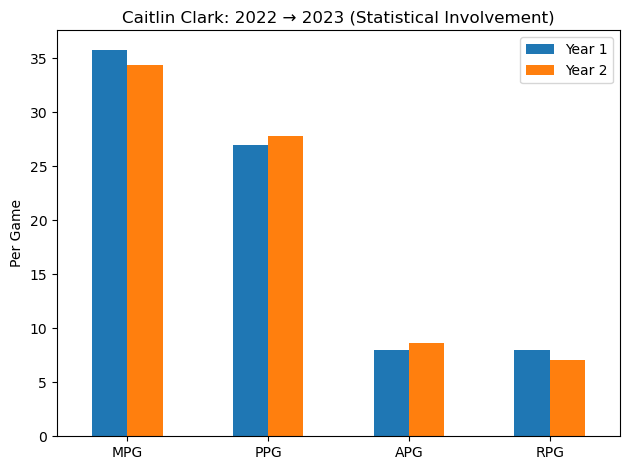

,Year 1,Year 2
MPG,35.8,34.4
PPG,27.0,27.8
APG,8.0,8.6
RPG,8.0,7.1


In [63]:
## Statistical Involvement Summary (Year-to-Year)
# Define stat group: Statistical Involvement
STAT_INVOLVEMENT = [
    "mp_per_g",
    "pts_per_g",
    "ast_per_g",
    "trb_per_g",
]

plot_stat_group(
    meta=profile["meta"],
    comp=profile["comparison"],
    stats=STAT_INVOLVEMENT,
    group_name="Statistical Involvement",
    y_label="Per Game",
    stat_labels=STAT_LABELS,
)


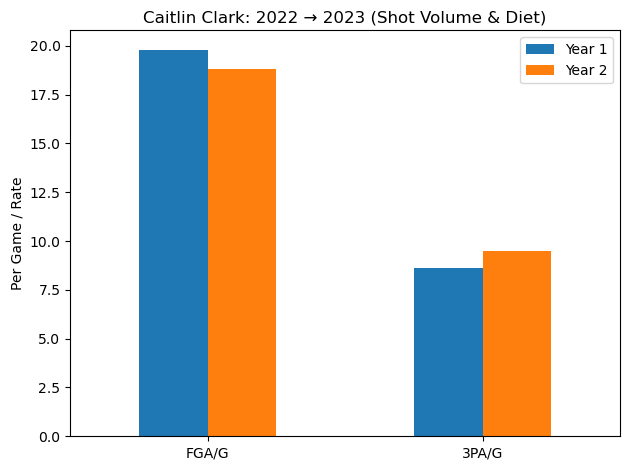

,Year 1,Year 2
FGA/G,19.8,18.8
3PA/G,8.6,9.5


In [68]:
## Shot Volume & Diet Summary (Year-to-Year)

SHOT_VOLUME_DIET = [
    "fga_per_g",
    "fg3a_per_g",
]

plot_stat_group(
    meta=profile["meta"],
    comp=profile["comparison"],
    stats=SHOT_VOLUME_DIET,
    group_name="Shot Volume & Diet",
    y_label="Per Game / Rate",
    stat_labels=STAT_LABELS,
)


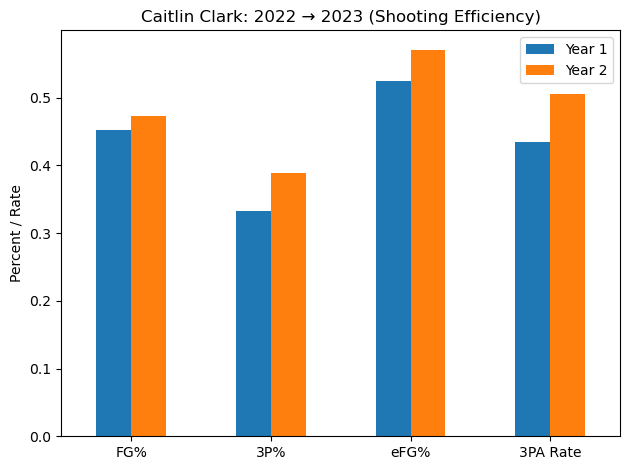

,Year 1,Year 2
FG%,0.452000,0.473000
3P%,0.332000,0.389000
eFG%,0.524000,0.571000
3PA Rate,0.434343,0.505319


In [66]:
## Shooting Efficiency (Year-to-Year)

SHOOTING_EFFICIENCY = [
    "fg_pct",
    "fg3_pct",
    "efg_pct",
    "fg3a_rate",
]

plot_stat_group(
    meta=profile["meta"],
    comp=profile["comparison"],
    stats=SHOOTING_EFFICIENCY,
    group_name="Shooting Efficiency",
    y_label="Percent / Rate",
    stat_labels=STAT_LABELS,
)
